In [1]:
pip install pandas numpy scikit-learn matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
# Step 0: Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pandas as pd

all_files = [
    r"C:\Users\Nithin G J\Desktop\RUL-PREDICTIVE-MAINTANANCE\data\text files\train_FD001.txt",
    r"C:\Users\Nithin G J\Desktop\RUL-PREDICTIVE-MAINTANANCE\data\text files\train_FD002.txt",
    r"C:\Users\Nithin G J\Desktop\RUL-PREDICTIVE-MAINTANANCE\data\text files\train_FD003.txt",
    r"C:\Users\Nithin G J\Desktop\RUL-PREDICTIVE-MAINTANANCE\data\text files\train_FD004.txt"
]
columns = ['unit_number', 'time_in_cycles'] + [f'sensor_{i}' for i in range(1, 22)]

# List to store dataframes
df_list = []

for file in all_files:
    df = pd.read_csv(file, sep=' ', header=None, names=columns, engine='python')
    df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col])
    df_list.append(df)

# Combine all datasets
data = pd.concat(df_list, ignore_index=True)

# Preview
print("Combined dataset head:\n", data.head())
print("\nMissing values:\n", data.isnull().sum())


Combined dataset head:
    unit_number  time_in_cycles  sensor_1  sensor_2  sensor_3  sensor_4  \
0       518.67          641.82   1589.70   1400.60     14.62     21.61   
1       518.67          642.15   1591.82   1403.14     14.62     21.61   
2       518.67          642.35   1587.99   1404.20     14.62     21.61   
3       518.67          642.35   1582.79   1401.87     14.62     21.61   
4       518.67          642.37   1582.85   1406.22     14.62     21.61   

   sensor_5  sensor_6  sensor_7  sensor_8  ...  sensor_12  sensor_13  \
0    554.36   2388.06   9046.19       1.3  ...    8138.62     8.4195   
1    553.75   2388.04   9044.07       1.3  ...    8131.49     8.4318   
2    554.26   2388.08   9052.94       1.3  ...    8133.23     8.4178   
3    554.45   2388.11   9049.48       1.3  ...    8133.83     8.3682   
4    554.00   2388.06   9055.15       1.3  ...    8133.80     8.4294   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0       0.03        392    

In [11]:
# Compute maximum cycle per engine
max_cycle = data.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycle.columns = ['unit_number', 'max_cycle']

# Merge max_cycle back into data
data = data.merge(max_cycle, on='unit_number', how='left')

# Compute RUL
data['RUL'] = data['max_cycle'] - data['time_in_cycles']

# Drop the temporary 'max_cycle' column
data = data.drop(columns=['max_cycle'])

# Verify
print(data[['unit_number', 'time_in_cycles', 'RUL']].head())


   unit_number  time_in_cycles   RUL
0       518.67          641.82  3.29
1       518.67          642.15  2.96
2       518.67          642.35  2.76
3       518.67          642.35  2.76
4       518.67          642.37  2.74


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


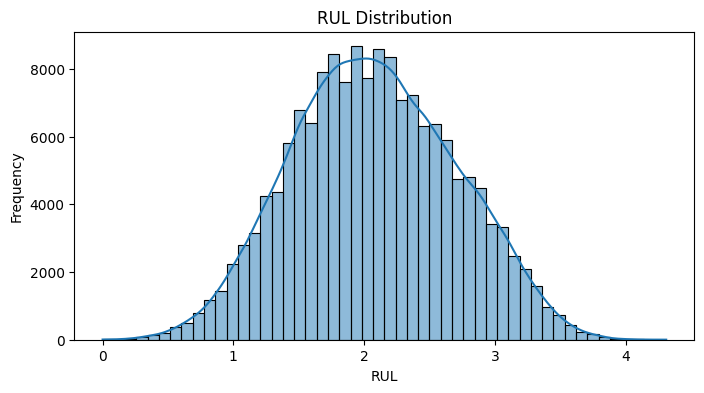

In [12]:
# Visualize RUL distribution
plt.figure(figsize=(8,4))
sns.histplot(data['RUL'], bins=50, kde=True)
plt.title('RUL Distribution')
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.show()


In [15]:
# ============================================
# Step 3: Preprocess Sensor Data (Normalization)
# ============================================
from sklearn.preprocessing import MinMaxScaler

sensor_cols = [f'sensor_{i}' for i in range(1, 22)]

scaler = MinMaxScaler()
data[sensor_cols] = scaler.fit_transform(data[sensor_cols])



c:\Users\Nithin G J\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_array_api.py:686: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\Nithin G J\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_array_api.py:706: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [18]:
# ============================================
# Step 4: Create Rolling Window Sequences
# ============================================

def create_sequences(df, window_size=30):
    sequences = []
    rul = []
    for unit in df['unit_number'].unique():
        unit_data = df[df['unit_number'] == unit].sort_values('time_in_cycles')
        sensor_data = unit_data[sensor_cols].values
        rul_data = unit_data['RUL'].values
        for i in range(len(sensor_data) - window_size + 1):
            sequences.append(sensor_data[i:i+window_size])
            rul.append(rul_data[i+window_size-1])
    return np.array(sequences), np.array(rul)

window_size = 30
X, y = create_sequences(data, window_size)

print("\nX shape:", X.shape)  # (num_sequences, window_size, num_sensors)
print("y shape:", y.shape)    # (num_sequences,)


X shape: (160185, 30, 21)
y shape: (160185,)


In [19]:
# ============================================
# Step 5: Save Processed Data
# ============================================

np.save('X.npy', X)
np.save('y.npy', y)
print("\nProcessed data saved as X.npy and y.npy")



Processed data saved as X.npy and y.npy


In [20]:
# ============================================
# Step 6: Verification
# ============================================

print("Missing values in X:", np.isnan(X).sum())
print("Missing values in y:", np.isnan(y).sum())



Missing values in X: 9611100
Missing values in y: 0


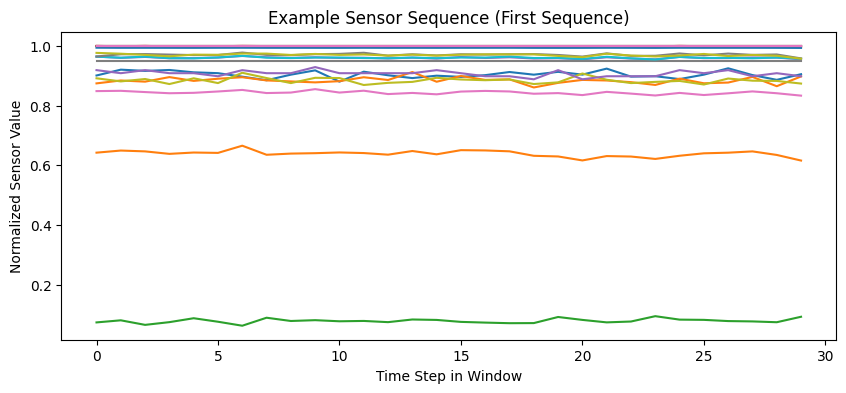

In [21]:
# Optional: Visualize first sequence
plt.figure(figsize=(10,4))
plt.plot(X[0])
plt.title("Example Sensor Sequence (First Sequence)")
plt.xlabel("Time Step in Window")
plt.ylabel("Normalized Sensor Value")
plt.show()
